In [2]:
# Instalamos las librería para obtener datos financieros reales
!pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Nos descargamos la informacion sobre la cotizacion del S&P 500 de 2018 hasta 2023
ticker = 'SPY'
data = yf.download(ticker, start="2018-01-01", end="2023-12-31")

# Calculamos los retornos logaritmicos
# Los usamos porque se pueden sumar a lo largo del tiempo, a diferencia de los porcentajes
data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

/tmp/ipython-input-1839694708.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2018-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


In [8]:
# Parámetros clave para Monte Carlo
mu = data['Returns'].mean()          # Retorno medio (Drift)
sigma = data['Returns'].std()       # Volatilidad (Desviación estándar)
last_price = data['Close'].iloc[-1].item()  # Precio inicial para la simulación (usamos .iloc[-1] porque nos lo pidel la libreria pandas)

print(f"Retorno promedio diario: {mu:.5f}")
print(f"Volatilidad diaria: {sigma:.5f}")
print(f"Último precio de cierre: ${last_price:.2f}")

Retorno promedio diario: 0.00044
Volatilidad diaria: 0.01289
Último precio de cierre: $463.84


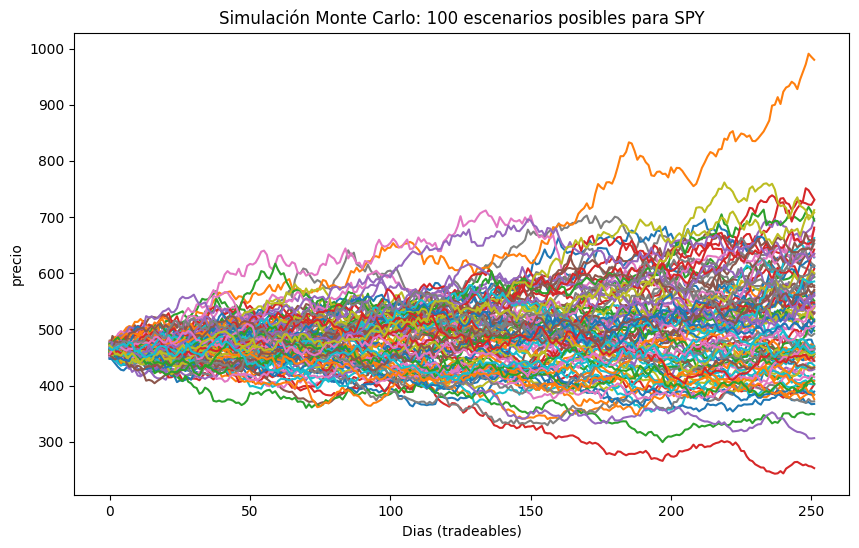

In [9]:
# Ahora definiremos el modelo
# Esta va a ser la base de nuestra simulacion Montecarlo

# Parametros iniciales
numDias = 252 # 252 dias de tradeables en un año
iter = 10000 # Numero de veces que simularemos el modelo
dt = 1 # Nuestros intervalos de tiempo seran de 1 dia

# Necesitamos generar una gran cantidad de numeros aleatorios
# Para ello usaremos una Dist Normal estandar y guardaremos los valores en una matriz
Z = np.random.standard_normal(size=(numDias, iter))

# Ahora calculamos los retornos diarios usando el Movimiento Browniano Geometrico
retornos = np.exp((mu - 0.5*sigma**2) * dt + (sigma*np.sqrt(dt)) * Z)

# Proyectamos los precios
caminos_precios = np.zeros_like(retornos) # Creamos una molde vacio del mismo tamaño que retornos
caminos_precios[0] = last_price # Este es el valor inicial con el que emprezamos en la fomula del movimiento browniano geometrico

# Aqui completamos la formula y usamos la funcion cumprod (cumulative product) de NumPy muy util que nos ahorra un pedazo de bucle
caminos_precios = last_price * np.cumprod(retornos, axis=0)

# Hacemos ahora una visualizacion sencilla con la libreria de mathplotlib.pyplot
plt.figure(figsize = (10, 6)) # Tamaño del grafico
plt.plot(caminos_precios[:, :100]) # Aqui estamos cogiendo todas las comulmnas pero solo las primeras 100 simulaciones para no saturar y tener una visualizacion mas limpia
plt.title(f"Simulación Monte Carlo: 100 escenarios posibles para {ticker}") # Añadimos un titulo al grafico para que quede mas limpio. El ticker en nuestro caso es el S&P 500
# Ahora marcamos ambos ejes
plt.xlabel("Dias (tradeables)")
plt.ylabel("precio")
# Mostamors el grafico
plt.show()

Precio Inicial: $463.84
VaR (95%): $361.81 (Hay un 95% de probabilidad de que el precio sea mayor a esto)
CVaR (95%): $333.66 (Si todo sale mal, este es el precio promedio esperado)


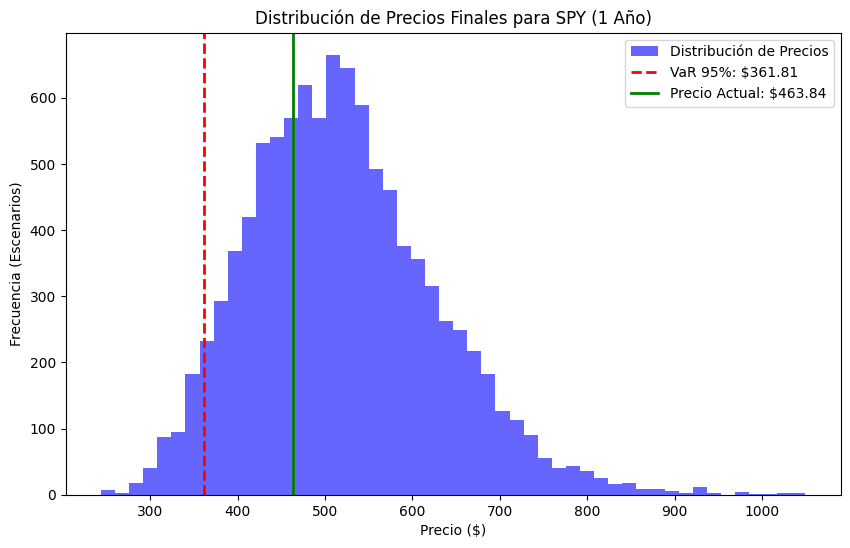

In [10]:
# --- ANÁLISIS DE RIESGO ---

# Seleccionamos solo los precios del último día de todas las simulaciones
precios_finales = caminos_precios[-1]

# Calculamos el VaR (Value at Risk) al 95% de confianza
# Significa buscar el percentil 5: el precio que deja por debajo al 5% de los peores escenarios
var_95 = np.percentile(precios_finales, 5)

# Calculamos el CVaR (Conditional Value at Risk) / Expected Shortfall
# Es el promedio de todos los precios que quedaron por debajo del VaR
cvar_95 = precios_finales[precios_finales <= var_95].mean()

# Resultados Numéricos
print(f"Precio Inicial: ${last_price:.2f}")
print(f"VaR (95%): ${var_95:.2f} (Hay un 95% de probabilidad de que el precio sea mayor a esto)")
print(f"CVaR (95%): ${cvar_95:.2f} (Si todo sale mal, este es el precio promedio esperado)")

# Visualización: Histograma de Precios Finales
plt.figure(figsize=(10,6))
plt.hist(precios_finales, bins=50, alpha=0.6, color='blue', label='Distribución de Precios')
plt.axvline(x=var_95, color='red', linestyle='--', linewidth=2, label=f'VaR 95%: ${var_95:.2f}')
plt.axvline(x=last_price, color='green', linestyle='-', linewidth=2, label=f'Precio Actual: ${last_price:.2f}')
plt.title(f"Distribución de Precios Finales para {ticker} (1 Año)")
plt.xlabel("Precio ($)")
plt.ylabel("Frecuencia (Escenarios)")
plt.legend()
plt.show()

Volatilidad Normal: 1.29%
Volatilidad Estrés: 2.58%


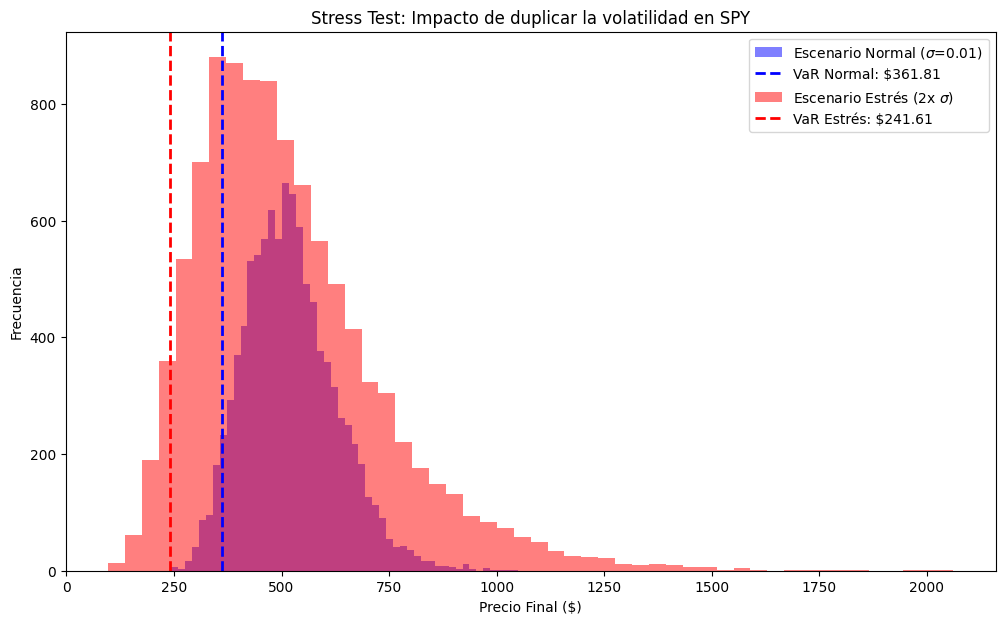

------------------------------
Diferencia de Riesgo (VaR): $120.20
Al duplicar la volatilidad, tu pérdida máxima esperada aumenta esa cantidad.


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Recuperamos las variables de tiempo (Corrección del NameError)
dias_a_predecir = 252  # 1 año bursátil
simulaciones = 10000   # Número de escenarios
dt = 1                 # Paso de tiempo (1 día)

# Definimos el escenario de estrés
# Asumimos que la volatilidad se duplica (Miedo en el mercado)
sigma_stress = sigma * 2

print(f"Volatilidad Normal: {sigma:.2%}")
print(f"Volatilidad Estrés: {sigma_stress:.2%}")

# Corremos la simulación de estrés
# Generamos nuevos números aleatorios (Z)
Z_stress = np.random.standard_normal((dias_a_predecir, simulaciones))

# Aplicamos la fórmula GBM con la sigma DUPLICADA
retornos_stress = np.exp((mu - 0.5 * sigma_stress**2) * dt + (sigma_stress * np.sqrt(dt) * Z_stress))

# Calculamos los precios acumulados (el camino del precio)
caminos_stress = last_price * retornos_stress.cumprod(axis=0)

# Calculamos VaR para comparar
precios_fin_normal = caminos_precios[-1] # Recuperamos los de la simulación anterior
precios_fin_stress = caminos_stress[-1]  # Los nuevos de estrés

var_95_normal = np.percentile(precios_fin_normal, 5)
var_95_stress = np.percentile(precios_fin_stress, 5)

# Visualización (Corrección del SyntaxWarning)
# Usamos doble barra \\ para que Python entienda que es un símbolo matemático LaTeX
plt.figure(figsize=(12, 7))

# Histograma Normal (Azul)
plt.hist(precios_fin_normal, bins=50, alpha=0.5, color='blue',
         label=f'Escenario Normal ($\\sigma$={sigma:.2f})')
plt.axvline(x=var_95_normal, color='blue', linestyle='--', linewidth=2,
            label=f'VaR Normal: ${var_95_normal:.2f}')

# Histograma Estrés (Rojo)
plt.hist(precios_fin_stress, bins=50, alpha=0.5, color='red',
         label=f'Escenario Estrés (2x $\\sigma$)')
plt.axvline(x=var_95_stress, color='red', linestyle='--', linewidth=2,
            label=f'VaR Estrés: ${var_95_stress:.2f}')

plt.title(f"Stress Test: Impacto de duplicar la volatilidad en {ticker}")
plt.xlabel("Precio Final ($)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

# Conclusión numérica
print("-" * 30)
print(f"Diferencia de Riesgo (VaR): ${var_95_normal - var_95_stress:.2f}")
print("Al duplicar la volatilidad, tu pérdida máxima esperada aumenta esa cantidad.")